In [1]:
# Welcome. Please run the full notebook and then you have the last code cell being where you run your simulations.
# You can pick which motion you want the world order to be based on and whether to run your code on cpu or qpu

In [2]:
import networkx as nx
import dwave_networkx as dnx
from dwave.system import LeapHybridSampler, DWaveSampler, EmbeddingComposite
import dimod
import pyreadr as pyr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#csvData = pd.read_csv("../dataverse_files/UNVotes-1.csv")
csvData = pyr.read_r('../dataverse_files/UNVotes.RData')



In [3]:
def draw_network(frustrated_edges, node_colors, G, edge_signs, countries):
    # outputs 2 figures. Figure 1 displays the 2 different node groups and the frustrated edges (orange) + non-frustrated edges (grey).
    # Figure 2 displays the 2 different node groups and the hostile edges (red) + friendly edges (green).
    # -1 represents enemies. +1 represents friends

    # producera array med färg strängar för noderna
    node_colors_string = []
    for node,integer in node_colors.items():
        if integer == 0:
            node_colors_string.append('teal')
        else:
            node_colors_string.append('yellow')

    # skapa array med färg strängar för kanterna
    edge_color_frus_string = []
    edge_color_raw_string = []
    frus_edges = list(frustrated_edges.keys())
    sign = list(frustrated_edges.values())
    i = 0
    for x in G.edges:
        if x in frus_edges:
            edge_color_frus_string.append('orange')
        else:
            edge_color_frus_string.append('grey')
        if edge_signs[i][2]['sign'] == -1:
            edge_color_raw_string.append('red')
        else:
            edge_color_raw_string.append('green')
        i = i + 1

    # plotta noderna. Gruppera noderna först
    pos=nx.circular_layout(G, scale=2)
    angs = np.linspace(0, 2*np.pi, 3)
    rad=4
    repos = []
    for ea in angs:
        #if ea > 0:
            repos.append(np.array([rad*np.cos(ea), rad*np.sin(ea)]))
    j = 0
    for i in list(pos.keys()):
        posx = 0
        if node_colors_string[j] == 'blue':
            posx = 0
        elif node_colors_string[j] == 'yellow':
            posx = 1
        else:
            pass
        pos[i] += repos[posx]
        j = j + 1


    fig1 = plt.figure(1)
    nx.draw(G, cmap=plt.get_cmap('plasma'), edge_cmap=plt.get_cmap('RdYlGn'), pos=pos, edgelist=G.edges, nodelist=G.nodes, width=0.5, node_color=node_colors_string, edge_color=edge_color_frus_string, with_labels=True)
    fig1.set_facecolor("#1C2833")
    #fig1.set_figheight(2)
    fig2 = plt.figure(2)
    nx.draw(G, pos=pos, cmap=plt.get_cmap('plasma'), edge_cmap=plt.get_cmap('RdYlGn'), edgelist=G.edges, nodelist=G.nodes, width=0.5, node_color=node_colors_string, edge_color=edge_color_raw_string, with_labels=True)
    fig2.set_facecolor("#1C2833")
    #fig2.set_figheight(2)

In [4]:
# format data. Output should be a graph with friendly and hostile countries based on if they voted the same on a given question.
# Abstaining from a vote doesn't necessarily mean you are friends or enemies, but we can solve this using the siths formula:
# "if you are not with me, you are my enemy".
def load_data(motion):
    csvData['completeVotes']['descr'][motion]
    #motion = 4

    motionData = csvData['completeVotes']['rcid'] #4
    votes = csvData['completeVotes']['vote']
    countriesData = csvData['completeVotes']['Country']
    countries, cindex = np.unique(countriesData, return_index=True)
    motions, mindex = np.unique(motionData, return_index=True)
    temp = countries
    for i in range(len(countries)):
        if len(countries[i]) > 3:
            temp[i] = '0'
        else:
            continue
    countries = [ x for x in countries if '0' not in x ]

    G = nx.Graph()
    # HERE YOU CAN ADJUST WHICH COUNTRIES ARE INCLUDED
    clist = ['USA', 'FRA', 'CHN', 'SWE', 'RUS', 'TWN', 'CAN', 'IRN', 'IND', 'GBR', 'DEU', 'JPN', 'KOR', 'ITA', 'AUS']
    countries = [x for x in countries if x in clist]
    G.add_nodes_from(countries)
    edges = []
    i = 0
    for x in countries[:-1]:
        j = i + 1
        for y in countries[j:]:
            if votes[i + mindex[motion]] != votes[j + mindex[motion]]:
                edges.append([x, y, {'sign': -1}])
            else:
                edges.append([x, y, {'sign': 1}])
            j = j + 1
        i = i + 1
    G.add_edges_from(edges)
    return G, edges, countries, mindex
    #pos = dnx.zephyr_layout(G)




In [8]:
# Problem solution computation, quantum version


def world_order_solver(motion, type, num_runs):

    #sampler = LeapHybridSampler()
    if type == 'qpu':
        sampler = dimod.TrackingComposite(EmbeddingComposite(DWaveSampler(solver={'qpu': True}))) #Q sampler
    elif type == 'cpu':
        sampler = dimod.RandomSampler()
    else:
        print("type has to be input as either qpu or cpu, depending on which hardware you wish to run the computations on.")

    G, edges, countries, mindex = load_data(motion)

    frustrated_edges, node_colors = dnx.structural_imbalance(G, sampler, num_reads=num_runs)#, chain_strength=5.0)
    set1 = int(sum(list(node_colors.values())))
    print("Can the world be divided into 2 stable factions based on their opinions on: " + csvData['completeVotes']['descr'][mindex[motion]])
    print("And which one will prevail as the most stable one?")
    print("One set has {} nodes; the other has {} nodes.".format(set1, len(countries)-set1))
    print("The network has {} frustrated relationships.".format(len(list(frustrated_edges.keys()))))


    # Visualize results

    draw_network(frustrated_edges, node_colors, G, edges, countries)




Welcome. Choose one of the following motions and solver type to see how the world order will look.
Can the world be divided into 2 stable factions based on their opinions on: TO ADOPT 4TH COMM. DRAFT RESOL. VIII (A/2061) ON THE ATTAINMENT OF THE OBJECTIVE OF SELF-GOVERNMENT AND INDEPENDENCE, BY TRUST TERRITORIES.
And which one will prevail as the most stable one?
One set has 5 nodes; the other has 10 nodes.
The network has 7 frustrated relationships.


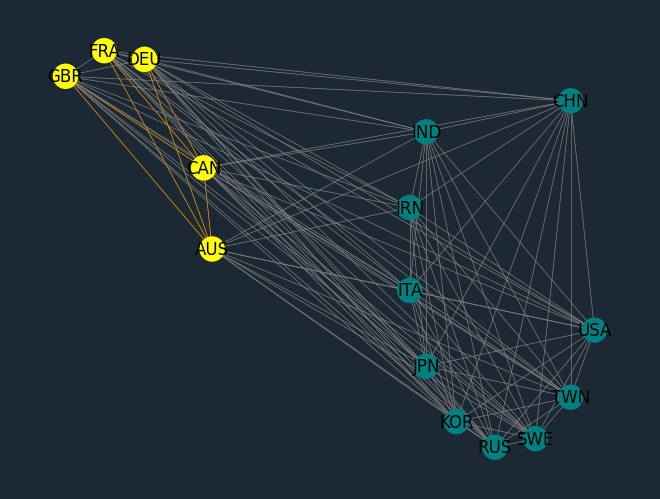

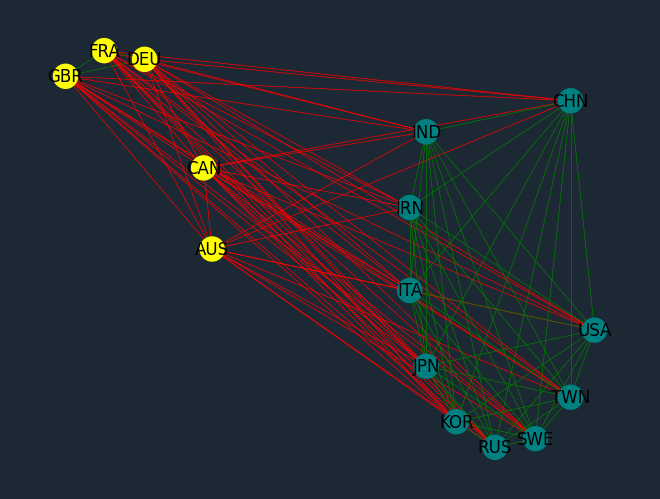

In [16]:
print("Welcome. Choose a motion and solver type to see how the world order will look.")
motion = 300
type = 'qpu'
num_runs = 100
world_order_solver(motion, type, num_runs)